In [1]:
import cv2 #computer vision tool working with resized images
import numpy as np # dealing with arrays
import os  #dealing with directories
from random import shuffle  #shuffling our data before passing it through CNN
from tqdm import tqdm  #percentage bar for tasks

TRAIN_DIR = '/Users/tashlin/kaggle/dogsvcats/train'
TEST_DIR = '/Users/tashlin/kaggle/dogsvcats/test'
IMG_SIZE = 50 #this could be changed but 50 should be large enough
LR = 1e-3
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR,'2conv-basic') #save model

In [2]:
'''Images labeled cat.1.jpg or dog.3.jpg, so we need to convert the labels to
an array for passing through our network'''

def label_img(img):
    # dog.93.jpg
    word_label = img.split('.')[0]
    if word_label == 'cat':
        return [1,0]
    elif word_label == 'dog':
        return [0,1]

In [3]:
'''Now we need to convert the actual training images into arrays'''
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
        

In [4]:
'''Convert actual TESTING data, this data does NOT have a label, which makes
the code below slightly different'''

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
#train_data = create_train_data() #only need to run once (done) unless img_size is changed
train_data = np.load('train_data.npy')

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
#IMG_SIZE = 50 

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
    

In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
#X is our training data, Y is the training label
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 11.28975 | time: 38.076s
| Adam | epoch: 005 | loss: 11.28975 - acc: 0.5097 -- iter: 24448/24500
Training Step: 1915  | total loss: 11.38402 | time: 39.182s
| Adam | epoch: 005 | loss: 11.38402 - acc: 0.5056 | val_loss: 11.42082 - val_acc: 0.5040 -- iter: 24500/24500
--


#### Not the best results, solution? Make a bigger network...

In [11]:
#reset the graph instance
import tensorflow as tf
tf.reset_default_graph()


In [12]:
#6 layers instead of 3 in the previous run through

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [13]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')


In [14]:
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [15]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.45516 | time: 51.343s
| Adam | epoch: 003 | loss: 0.45516 - acc: 0.7826 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.44809 | time: 52.471s
| Adam | epoch: 003 | loss: 0.44809 - acc: 0.7856 | val_loss: 0.53369 - val_acc: 0.7260 -- iter: 24500/24500
--


In [16]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/tashlin/kaggle/dogsvcats/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [17]:
import tensorflow as tf
tf.reset_default_graph()

In [18]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


In [19]:
if os.path.exists('/Users/tashlin/dogsvcats/{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [20]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [21]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 3829  | total loss: 0.33398 | time: 49.602s
| Adam | epoch: 010 | loss: 0.33398 - acc: 0.8485 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.32000 | time: 50.730s
| Adam | epoch: 010 | loss: 0.32000 - acc: 0.8574 | val_loss: 0.56814 - val_acc: 0.7800 -- iter: 24500/24500
--
INFO:tensorflow:/Users/tashlin/kaggle/dogsvcats/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:12<00:00, 1008.14it/s]


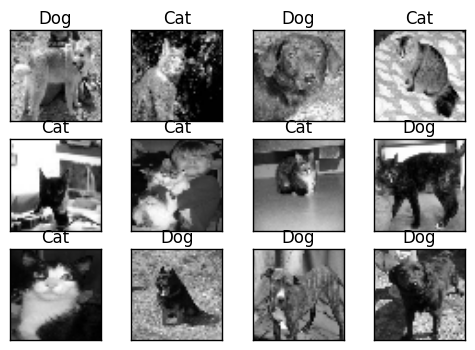

In [25]:
#Visualize the fruits of our labour

import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [26]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [00:19<00:00, 632.72it/s]
